In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math
import time

from IPython.display import clear_output
%matplotlib inline

from torch.autograd import Variable

torch.set_default_dtype(torch.float64)

import subprocess

In [3]:
PATH = os.getcwd()
print(PATH)

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type(torch.DoubleTensor)
    print('Using GPU')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type(torch.DoubleTensor)
    print('Using CPU')
    
    
def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

print(get_gpu_memory_map())

/home/ct2243/Desktop/RESEARCH_ML/SymplecticNets
Using GPU
{0: 1176}


# Spring-Mass physics


In [4]:
# physics

n_object = 10
n_dim = 1

T = 10.

In [5]:
def springmass(q0, p0, M, K, T, nsteps):
    dt = T/nsteps
    q, p = q0, p0
    
    qs = np.zeros((len(q0),nsteps+1))
    qs[:,0] = q.flatten()
    
    ps = np.zeros((len(p0),nsteps+1))
    ps[:,0] = p.flatten()
    
    
    for i in range(nsteps):
        Fq = (- np.dot(K, q))
        q = q + p/M * dt + 1/2. * Fq/M * dt**2
        p = p + 1/2. * (Fq + (- np.dot(K, q)) ) * dt
        
        
        qs[:,i+1] = q.flatten()
        ps[:,i+1] = p.flatten()

    return qs, ps 

In [6]:
nmass = n_object
nspring = nmass + 1
M = np.ones(nmass).reshape((-1,1))
k = np.ones(nspring)
K = np.diag(k[:-1]+k[1:]) - np.diag(k[1:-1], -1) - np.diag(k[1:-1], 1)
print(K)

[[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2.]]


In [7]:
q0 = np.random.randn(n_object).reshape((-1,1))
p0 = np.random.randn(n_object).reshape((-1,1))

q0 = np.random.randn(nmass).reshape((-1,1))
p0 = np.random.randn(nmass).reshape((-1,1))

In [8]:
qs, ps = springmass(q0, p0, M, K, T, 1000)

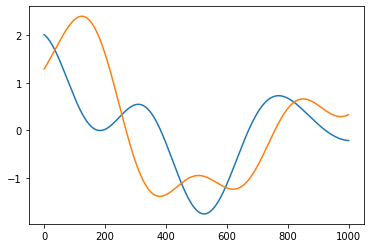

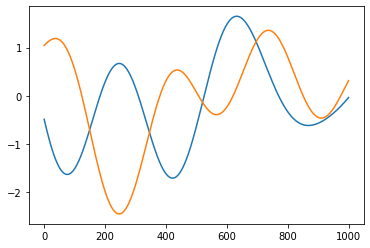

In [9]:
plt.plot(qs[0,:])
plt.plot(qs[1,:])
plt.figure()
plt.plot(ps[0,:])
plt.plot(ps[1,:])

## Network Architectures

In [10]:
# COMPLETE

# takes either (q, t) or (p, t) and outputs a scalar
# perhaps should be named 'symplecticMap', as each mixingNet is a symplectic map

class diagonal_linear(torch.nn.Module):
    def __init__(self, n):
        super(diagonal_linear, self).__init__()
        diag_ = 1./torch.sqrt(torch.Tensor([n])) * ( torch.rand(n) - 0.5 )
        self.D = nn.Parameter(torch.diag(diag_), requires_grad=True)
        self.bias = nn.Parameter(1./torch.sqrt(torch.Tensor([n])) * ( torch.rand(n) - 0.5 ))
        
    def forward(self, X):
        return torch.mm(X,self.D) + self.bias

    
class symmetric_linear(torch.nn.Module):
    def __init__(self, n):
        super(symmetric_linear, self).__init__()
        self.L = nn.Parameter( 1./torch.sqrt(torch.Tensor([n])) * ( torch.rand(n,n) - 0.5 ) )
        
    def forward(self, X):
        return torch.matmul(X,(self.L.t() + self.L)/2.)
    
    
# irrotational n-hidden layer mixing Net;
class mixingNet(torch.nn.Module):

    def __init__(self, h_sizes, n_object = n_object, n_dim = n_dim):
        super(mixingNet, self).__init__()
        
        # input/output layer, decomposed because need to do weight sharing
        self.linear_t1 = nn.Linear(1,h_sizes[0], bias = False)
        self.qplinear = nn.Linear( (n_object * n_dim), h_sizes[0], bias = False) # nd x nd for n objects in d dimensions.
        self.bias1 = nn.Parameter(1./torch.sqrt(torch.Tensor([h_sizes[0]])) * ( torch.rand(h_sizes[0]) - 0.5 ))
        
        # hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(  diagonal_linear(h_sizes[k])  )

        # skip connection. no need to include t(?)
        self.skip = symmetric_linear((n_object * n_dim)) # nd x nd for n objects in d dimensions.
        self.linear_t2 = nn.Linear(1,1, bias = False)
        self.bias2 = nn.Parameter(torch.rand(1))
        
    def forward(self, q_p, tt):
        
        # without linear_t2 seems better.
        residual =  self.skip(q_p) #+self.linear_t2(tt) 
        act = torch.nn.Softplus()
        X = act(self.linear_t1(tt) + self.qplinear(q_p) + self.bias1  )
        for layer in self.hidden:
            X = act(layer(X))

        # output layer
        X = torch.mm(X, self.qplinear.weight) + residual + self.bias2 
        
        return X

class symplectic_symmetric_Net(torch.nn.Module):
    
    def __init__(self, h_sizes):
        super(symplectic_symmetric_Net, self).__init__()
        
        self.n_transforms = 8
        self.sp_mapsAC = nn.ModuleList()
        self.sp_mapsB = nn.ModuleList()
        for k in range(self.n_transforms):
            self.sp_mapsAC.append(  mixingNet(h_sizes)  )
            self.sp_mapsB.append(  mixingNet(h_sizes)  )

                
    def forward(self, qq, pp, tt):
        
        def symm_transform(m1, m2, qq, pp, dt):
            qq = qq + (m1( pp,dt) ) * dt/2. #(torch.exp(dt/2.) - 1) 
            pp = pp + m2( qq,dt) * dt #(torch.exp(dt) - 1)
            qq = qq + (m1( pp,dt) ) * dt/2. #(torch.exp(dt/2.) - 1) 
            return qq, pp
        
        for m1,m2 in list(zip(self.sp_mapsAC, self.sp_mapsB)):
            qq, pp = symm_transform(m1, m2, qq, pp, tt/(2 * self.n_transforms))
        
        for m1,m2 in reversed(list(zip(self.sp_mapsAC, self.sp_mapsB))):
            qq, pp = symm_transform(m1, m2, qq, pp, tt/(2 * self.n_transforms))
        
        
        return qq, pp



In [11]:
# data
Npoints = 2048
#q0_start = np.random.uniform(-0.5,0.5, n_object).reshape((n_object, -1))
#p0_start = np.random.uniform(-0.5,0.5, n_object).reshape((n_object, -1))

q0_start = np.zeros(n_object).reshape((n_object, -1))
p0_start = np.zeros(n_object).reshape((n_object, -1))

q0_start = np.repeat(q0_start, Npoints, axis = 1).T
p0_start = np.repeat(p0_start, Npoints, axis = 1).T


In [12]:
# Training
n_train = Npoints
batch_size = int(n_train)

criterion = nn.MSELoss()

lossdata = []

h_sizes = [20] * 2

spTransform = symplectic_symmetric_Net(h_sizes).to(device = device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('number of parameters:')
count_parameters(spTransform)

number of parameters:


12192

In [14]:
num_epochs = 2000
learning_rate = 2e-2

optimizer_spTransform = torch.optim.LBFGS(spTransform.parameters(),lr = learning_rate, history_size = 100, tolerance_change = 1e-16)
#optimizer_spTransform = torch.optim.Adam(spTransform.parameters(),lr = 1e-3)


epoch [1540/2000], loss:0.0138122505594940


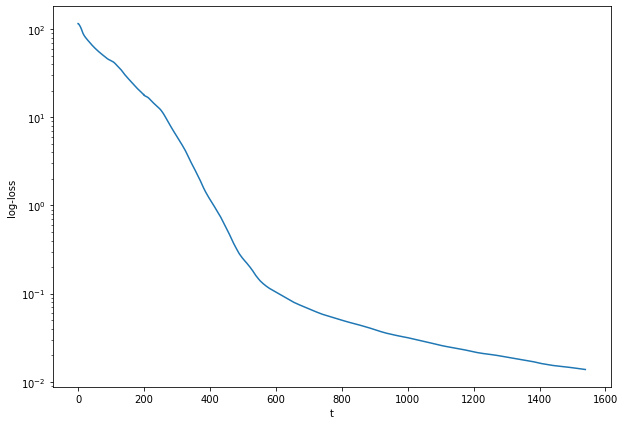

tensor(0.0138, device='cuda:0')


KeyboardInterrupt: 

In [15]:
K_tensor = torch.Tensor(K).to(device = device)
M_tensor = torch.Tensor(M).to(device = device)

for epoch in range(num_epochs):
    #np.random.seed(0)
    if epoch % 200 ==0 :
        #q0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))
        #p0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))
        
        q0_noise = 3 * np.random.randn( n_object * Npoints).reshape((-1,n_object))
        p0_noise = 3 * np.random.randn( n_object * Npoints).reshape((-1,n_object))

        q0 = q0_start + q0_noise
        p0 = p0_start + p0_noise
        
        np.random.seed(0)
        t = np.random.uniform(low = 0, high = T, size = Npoints).reshape((-1,1))
        #t = np.random.uniform(low = 0, high = min(T, T * (epoch + 400)/num_epochs), size = (Npoints)).reshape((-1,1))


        shuffle_index = torch.randperm(n_train)

        tt_ = torch.Tensor(t.reshape(-1,1))

        tt = tt_[shuffle_index].to(device=device)
        tt.requires_grad_(True)

        theta0_, p0_ = q0, p0
        theta0_, p0_ = torch.Tensor(theta0_.reshape(-1,n_object)), torch.Tensor(p0_.reshape(-1,n_object))    
        theta0, p0 = theta0_[shuffle_index].to(device=device), p0_[shuffle_index].to(device=device)

        theta0.requires_grad_(True), p0.requires_grad_(True)

        ## required for supervised learning.
        #  thetat = torch.Tensor(labels[:,0].reshape(-1,1))[shuffle_index].to(device = device)
        #  pt = torch.Tensor(labels[:,1].reshape(-1,1))[shuffle_index].to(device = device)

        K_tensor = torch.Tensor(K).to(device = device)
        M_tensor = torch.Tensor(M).to(device = device)

    
    for i in range(int(len(tt)/batch_size)):
        
        theta0i = theta0[i*batch_size:(i+1)*batch_size]
        p0i = p0[i*batch_size:(i+1)*batch_size]
        tti = tt[i*batch_size:(i+1)*batch_size]

        # Forward 
        qti, pti = spTransform(theta0i, p0i, tti)
        
        qtis = qti.split(1, dim = 1)
        vec = qtis[0].new(qtis[0].shape).fill_(1)
        d_q_d_ts = [torch.autograd.grad(qti, tti, vec, create_graph = True, retain_graph = True)[0] for qti in qtis]
        d_q_d_ts_cat = torch.cat(d_q_d_ts, dim = 1)

        ptis = pti.split(1, dim = 1)
        vec = ptis[0].new(ptis[0].shape).fill_(1)
        d_p_d_ts = [torch.autograd.grad(pti, tti, vec, create_graph = True, retain_graph = True)[0] for pti in ptis]
        d_p_d_ts_cat = torch.cat(d_p_d_ts, dim = 1)

                
        # 1. autodiff to get these
        #d_H_d_p, = torch.autograd.grad(Hamiltonian, pti, Hamiltonian.new(Hamiltonian.shape).fill_(1), create_graph = True)
        #d_H_d_q, = torch.autograd.grad(Hamiltonian, qti, Hamiltonian.new(Hamiltonian.shape).fill_(1), create_graph = True)

        # 2. compute by hand
        d_H_d_p = pti #p/m # to be precise
        d_H_d_q = torch.mm(qti, K_tensor.t()) #k*q # to be precise

        loss = criterion(d_q_d_ts_cat,  d_H_d_p) + criterion(d_p_d_ts_cat, - d_H_d_q) 

        
        # Backward
        def closure():
            return loss

        optimizer_spTransform.zero_grad()
        
        loss.backward(retain_graph = True)
        
        optimizer_spTransform.step(closure)


    lossdata.append(float(loss.data))
    print(loss.data)

    if(epoch ==0):
        print('epoch [{}/{}], loss:{:.16f}'.format(epoch, num_epochs, loss.data))

    if( (epoch+1) % 20 ==0):
        clear_output()
        print('epoch [{}/{}], loss:{:.16f}'.format(epoch + 1, num_epochs, loss.data))
        if(len(lossdata)>10):
            plt.figure(figsize = (10,7))
            plt.xlabel('t')
            plt.ylabel('log-loss')
            plt.semilogy(np.array(lossdata)[-5000:])
            plt.show()

In [16]:
#q0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))
#p0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))

q0_noise = 3 * np.random.randn( n_object * Npoints).reshape((-1,n_object))
p0_noise = 3 * np.random.randn( n_object * Npoints).reshape((-1,n_object))


# pick one of the starting points.
q0_test = (q0_start + q0_noise)[3]
p0_test = (p0_start + p0_noise)[3]

q0_test = q0_test.reshape((-1,1))
p0_test = p0_test.reshape((-1,1))


In [17]:
q0_test.shape
p0_test.shape

(10, 1)

In [18]:
nmass = n_object
nspring = nmass + 1
M = np.ones(nmass).reshape((-1,1))
k = np.ones(nspring)
K = np.diag(k[:-1]+k[1:]) - np.diag(k[1:-1], -1) - np.diag(k[1:-1], 1)

qhist, phist = springmass(q0_test, p0_test, M, K, T, Npoints-1)

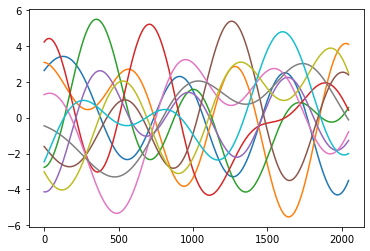

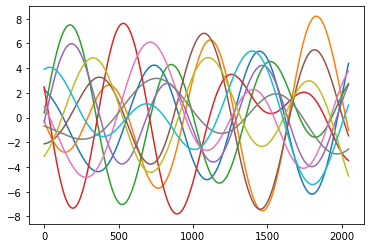

In [19]:
for i in range(10):
    plt.plot(qhist[i,:])

plt.figure()
for i in range(10):
    plt.plot(phist[i,:])

In [20]:
q0_start[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
q0_test = torch.Tensor(q0_test.reshape(-1,n_object)).to(device=device)
p0_test = torch.Tensor(p0_test.reshape(-1,n_object)).to(device=device)

t_test = (np.arange(Npoints)/(Npoints-1) * T).reshape((-1,1))
t_test = torch.Tensor(t_test.reshape(-1,1)).to(device=device)

qt_test, pt_test = spTransform(q0_test, p0_test, t_test)


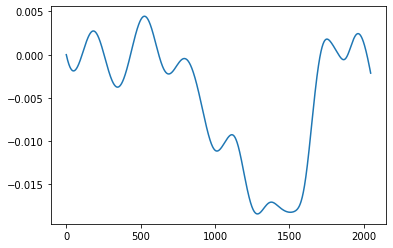

In [22]:
E_hist = []

for i in range(Npoints):
    Pot_t = 1/2. * pt_test[i].detach().cpu().numpy().reshape(1,-1) @ np.diag(M.reshape(-1))@ pt_test[i].detach().cpu().numpy()
    Kin_t = 1/2. * qt_test[i].detach().cpu().numpy().reshape(1,-1) @ K@ qt_test[i].detach().cpu().numpy()

    E_hist.append(float(Pot_t + Kin_t))

E_hist = np.array(E_hist)
    
plt.plot((E_hist - (E_hist[0])) /E_hist)


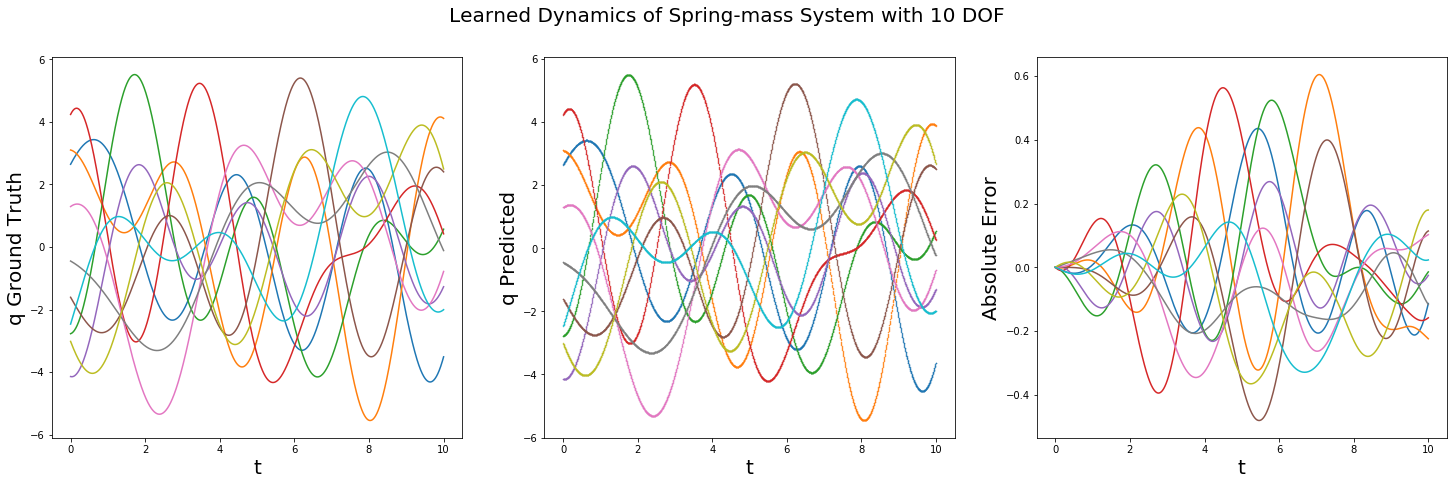

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,7))
f.suptitle('Learned Dynamics of Spring-mass System with 10 DOF', fontsize = 20)

ax1.set_ylabel('q Ground Truth', fontsize = 20)
ax2.set_ylabel('q Predicted', fontsize = 20)
ax3.set_ylabel('Absolute Error', fontsize = 20)

ax1.set_xlabel('t', fontsize = 20)
ax2.set_xlabel('t', fontsize = 20)
ax3.set_xlabel('t', fontsize = 20)


for i in range(n_object):
    ax1.plot(np.arange(Npoints)*T/(Npoints-1), qhist[i,:])

for i in range(n_object):
    ax2.scatter(t_test.detach().cpu().numpy(), qt_test[:,i].detach().cpu().numpy(), s = 0.2)

for i in range(n_object):
    ax3.plot(np.arange(Npoints)*T/(Npoints-1), qt_test[:,i].detach().cpu().numpy() - qhist[i,:])

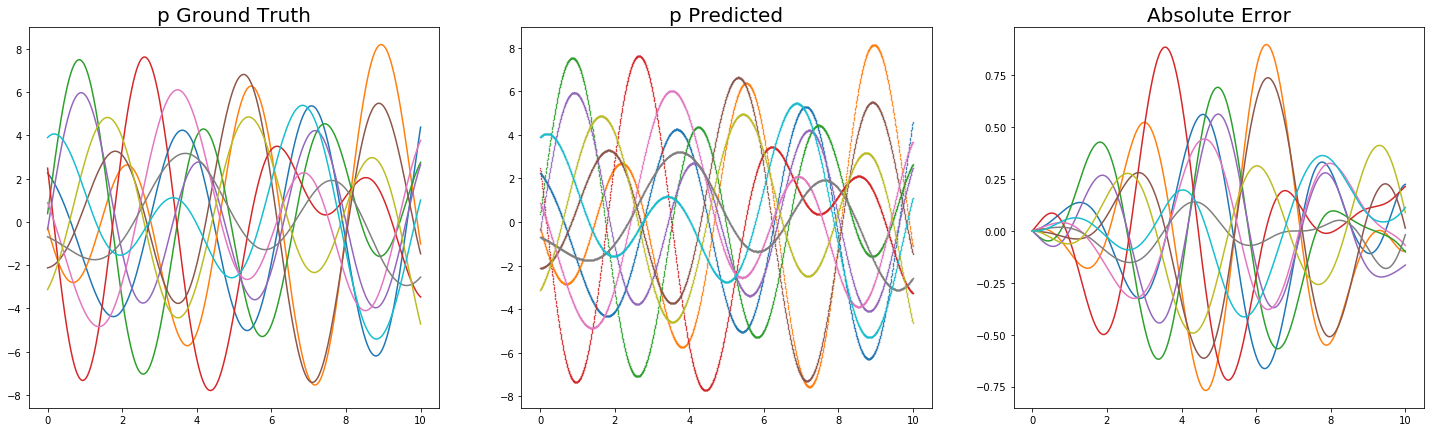

In [27]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,7))


ax1.set_title('p Ground Truth', fontsize = 20)
ax2.set_title('p Predicted', fontsize = 20)
ax3.set_title('Absolute Error', fontsize = 20)

for i in range(n_object):
    ax1.plot(np.arange(Npoints)*T/(Npoints-1), phist[i,:])

for i in range(n_object):
    ax2.scatter(t_test.detach().cpu().numpy(), pt_test[:,i].detach().cpu().numpy(), s = 0.2)

for i in range(n_object):
    ax3.plot(np.arange(Npoints)*T/(Npoints-1), pt_test[:,i].detach().cpu().numpy() - phist[i,:])